In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import tqdm
import json
import polars as pl
import numpy as np
import seaborn as sns

In [ ]:
PRE_DIR = '/content/drive/MyDrive/Colab Notebooks/Nhom_4/2. Thực Hành/Visualize Data/Preprocessed Data'
MODEL_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Nhom_4/2. Thực Hành/Visualize Data/Model Data'

KG:
- Course
- Teacher
- School
- Fields
- Concepts

CKG:
- User-item interactions
- KG

Tables used:
- Entities:
    - Course Info
    - School
    - Teacher
    - Field/Discipline
    - Concept
    - Student Profile
- Relations:
    - course-field.json
    - course-school.txt
    - course-teacher.txt
    - concept-course
    
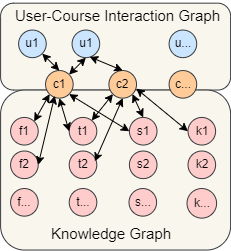

# Create new variables

- Nhóm định nghĩa sự phổ biến của các thực thể như sau:
    - course: số lần đăng ký khóa học
    - teacher:
        - số lần tham gia khóa học
        - số lần đăng ký khóa học trung bình từ user
    - school:
        - số lần tổ chức khóa học
        - số lần đăng ký khóa học trung bình từ user

- Cần thống kê để xác nhận (mọi người góp ý)
- Có thể thử chọn 1 mốc thời gian nhất định, chia làm khoảng thời gian trước và hiện tại. Nếu số lần đăng ký trong thời điểm trước nhiều thì số lần đăng ký có nhiều không? Này t không chắc hợp lý.

# N-core filtering

## User - item bipartite graph filtering

5 - core: Remove users, items less than 5 interactions

Ở giai đoạn EDA, ta đã lọc bỏ các item không hợp lệ, nên ở đây sẽ không cần load course json lên

In [ ]:
N_CORE = 5

In [ ]:
interactions = pl.read_ndjson(os.path.join(PRE_DIR, 'entities/user_eda.json')) \
            .select(['id', 'course_order', 'enroll_time']) \
            .explode('course_order', 'enroll_time') \
            .rename({'course_order': 'course', 'id': 'user'}) \
            .with_columns(pl.col('course').map_elements(lambda c: f'C_{str(c)}'))
interactions

user,course,enroll_time
str,str,str
"""U_22""","""C_682129""","""2019-10-12 10:…"
"""U_24""","""C_597314""","""2019-06-12 17:…"
"""U_24""","""C_597208""","""2019-06-17 15:…"
"""U_24""","""C_682129""","""2019-10-06 16:…"
"""U_24""","""C_674910""","""2019-10-08 17:…"
"""U_24""","""C_707038""","""2019-10-13 13:…"
"""U_24""","""C_682312""","""2019-10-18 07:…"
"""U_24""","""C_696994""","""2019-10-24 10:…"
"""U_24""","""C_707360""","""2019-11-01 16:…"


In [ ]:
interactions.describe()

describe,user,course,enroll_time
str,str,str,str
"""count""","""11523022""","""11523022""","""11523022"""
"""null_count""","""0""","""0""","""0"""
"""mean""",null,null,null
"""std""",null,null,null
"""min""","""U_10000""","""C_1017355""","""2019-05-08 14:…"
"""25%""",null,null,null
"""50%""",null,null,null
"""75%""",null,null,null
"""max""","""U_999999""","""C_956450""","""2020-12-08 03:…"


In [ ]:
def filter_n_core_interactions(interactions):
    old_size = -1

    while (old_size != interactions.shape[0]):
        old_size = interactions.shape[0]

        # Filter users who enrolled less than n-core courses
        course_counts_of_user = interactions.group_by('user').count()
        valid_users = course_counts_of_user.filter(pl.col('count') >= N_CORE)['user']
        interactions = interactions.filter(pl.col('user').is_in(valid_users))

        # Filter courses which were enrolled by less than n_core users
        user_counts_of_course = interactions.group_by('course').count()
        valid_courses = user_counts_of_course.filter(pl.col('count') >= N_CORE)['course']
        interactions = interactions.filter(pl.col('course').is_in(valid_courses))

        print(f'New size: {interactions.shape[0]}')

    print('# of users   : ', interactions['user'].n_unique())
    print('# of courses : ', interactions['course'].n_unique())

    return interactions

In [ ]:
interactions = filter_n_core_interactions(interactions)

New size: 7470942
New size: 7470883
New size: 7470883
# of users   :  373351
# of courses :  3118


Do số lượng users vẫn quá nhiều, không đủ tài nguyên tính toán, nên nhóm sẽ chỉ giữa lại 100K users, sau đó 5-core filtering tiếp

In [ ]:
import random

kept_users = random.sample(list(set(interactions['user'])), 100000)
len(set(kept_users))

100000

In [ ]:
interactions = filter_n_core_interactions(
    interactions.filter(pl.col('user').is_in(kept_users))
)

interactions

New size: 1992272
New size: 1992150
New size: 1992150
# of users   :  99969
# of courses :  2831


user,course,enroll_time
str,str,str
"""U_146""","""C_680824""","""2020-02-03 22:…"
"""U_146""","""C_766203""","""2020-02-03 22:…"
"""U_146""","""C_873864""","""2020-02-03 22:…"
"""U_146""","""C_682443""","""2020-02-19 20:…"
"""U_146""","""C_682222""","""2020-02-19 21:…"
"""U_146""","""C_680845""","""2020-04-14 20:…"
"""U_185""","""C_696729""","""2019-09-18 10:…"
"""U_185""","""C_707096""","""2019-11-27 08:…"
"""U_185""","""C_943255""","""2019-12-28 16:…"


In [ ]:
# interactions.write_csv(os.path.join(MODEL_DATA_DIR, 'interactions_n_core.txt'),
#                        separator='\t', include_header=False)

## Knowledge Graph filtering

Remove entities less than 5 ocurrences in triplet and relations less than 25 ocurrences in triplets

### course-concept

In [ ]:
course_concept_df = pl.read_csv(os.path.join(PRE_DIR, 'relations/concept-course_eda.txt'),
                                separator='\t', has_header=False, new_columns=['concept', 'course'])
course_concept_df

concept,course
str,str
"""K_相电源_控制科学与工程""","""C_681460"""
"""K_控制线缆_控制科学与工程…","""C_681460"""
"""K_pid指令_控制科学与工…","""C_681460"""
"""K_控制自动化_控制科学与工…","""C_681460"""
"""K_转换负值_控制科学与工程…","""C_681460"""
"""K_内部继电器_控制科学与工…","""C_681460"""
"""K_并行分支_控制科学与工程…","""C_681460"""
"""K_管网水压_控制科学与工程…","""C_681460"""
"""K_设备接线_控制科学与工程…","""C_681460"""


In [ ]:
course_concept_df = course_concept_df.rename({'course': 'h', 'concept': 't'}) \
                                    .with_columns(pl.lit('course.concept').alias('r')) \
                                    .select(['h', 'r', 't'])

course_concept_df

h,r,t
str,str,str
"""C_681460""","""course.concept…","""K_相电源_控制科学与工程"""
"""C_681460""","""course.concept…","""K_控制线缆_控制科学与工程…"
"""C_681460""","""course.concept…","""K_pid指令_控制科学与工…"
"""C_681460""","""course.concept…","""K_控制自动化_控制科学与工…"
"""C_681460""","""course.concept…","""K_转换负值_控制科学与工程…"
"""C_681460""","""course.concept…","""K_内部继电器_控制科学与工…"
"""C_681460""","""course.concept…","""K_并行分支_控制科学与工程…"
"""C_681460""","""course.concept…","""K_管网水压_控制科学与工程…"
"""C_681460""","""course.concept…","""K_设备接线_控制科学与工程…"


### course-teacher

In [ ]:
course_teacher_df = pl.read_csv(os.path.join(PRE_DIR, 'relations/course-teacher_eda.txt'),
                                separator='\t', has_header=False, new_columns=['course', 'teacher'])
course_teacher_df

course,teacher
str,str
"""C_584313""","""T_20"""
"""C_597229""","""T_43"""
"""C_597365""","""T_155"""
"""C_629503""","""T_204"""
"""C_629503""","""T_206"""
"""C_629520""","""T_223"""
"""C_654505""","""T_82"""
"""C_654505""","""T_78"""
"""C_654551""","""T_21"""


In [ ]:
course_teacher_df = course_teacher_df.rename({'course': 'h', 'teacher': 't'}) \
                                    .with_columns(pl.lit('course.teacher').alias('r')) \
                                    .select(['h', 'r', 't'])

course_teacher_df

h,r,t
str,str,str
"""C_584313""","""course.teacher…","""T_20"""
"""C_597229""","""course.teacher…","""T_43"""
"""C_597365""","""course.teacher…","""T_155"""
"""C_629503""","""course.teacher…","""T_204"""
"""C_629503""","""course.teacher…","""T_206"""
"""C_629520""","""course.teacher…","""T_223"""
"""C_654505""","""course.teacher…","""T_82"""
"""C_654505""","""course.teacher…","""T_78"""
"""C_654551""","""course.teacher…","""T_21"""


### Course-school

In [ ]:
course_school_df = pl.read_csv(os.path.join(PRE_DIR, 'relations/course-school_eda.txt'),
                                separator='\t', has_header=False, new_columns=['course', 'school'])
course_school_df

course,school
str,str
"""C_584313""","""S_1"""
"""C_584329""","""S_1"""
"""C_584381""","""S_1"""
"""C_597208""","""S_1"""
"""C_597225""","""S_6"""
"""C_597229""","""S_1"""
"""C_597291""","""S_12"""
"""C_597307""","""S_1"""
"""C_597314""","""S_1"""


In [ ]:
course_school_df = course_school_df.rename({'course': 'h', 'school': 't'}) \
                                    .with_columns(pl.lit('course.school').alias('r')) \
                                    .select(['h', 'r', 't'])

course_school_df

h,r,t
str,str,str
"""C_584313""","""course.school""","""S_1"""
"""C_584329""","""course.school""","""S_1"""
"""C_584381""","""course.school""","""S_1"""
"""C_597208""","""course.school""","""S_1"""
"""C_597225""","""course.school""","""S_6"""
"""C_597229""","""course.school""","""S_1"""
"""C_597291""","""course.school""","""S_12"""
"""C_597307""","""course.school""","""S_1"""
"""C_597314""","""course.school""","""S_1"""


### Course - field

In [ ]:
course_field_df = pl.read_ndjson(os.path.join(PRE_DIR, 'entities/course_eda.json')) \
                    .select('id', 'field') \
                    .explode('field') \
                    .rename({'id': 'course'})

course_field_df

course,field
str,str
"""C_584313""","""lịch sử"""
"""C_584313""","""trường dạy tiế…"
"""C_584329""","""toán học"""
"""C_584329""","""kinh tế học ứn…"
"""C_584329""","""vật lý"""
"""C_584329""","""kinh tế lý thu…"
"""C_584381""","""báo chí"""
"""C_584381""","""nghệ thuật"""
"""C_597208""","""khoa học và cô…"


In [ ]:
course_field_df.describe()

describe,course,field
str,str,str
"""count""","""3917""","""683"""
"""null_count""","""0""","""3234"""
"""mean""",null,null
"""std""",null,null
"""min""","""C_1017355""","""báo chí"""
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""C_956450""","""địa vật lý"""


In [ ]:
course_field_df = course_field_df.drop_nulls().unique() \
                                .rename({'course': 'h', 'field': 't'}) \
                                .with_columns(pl.lit('course.field').alias('r')) \
                                .select(['h', 'r', 't'])
course_field_df

h,r,t
str,str,str
"""C_584313""","""course.field""","""lịch sử"""
"""C_584329""","""course.field""","""toán học"""
"""C_584329""","""course.field""","""kinh tế lý thu…"
"""C_629520""","""course.field""","""y học lâm sàng…"
"""C_629503""","""course.field""","""quản lý thông …"
"""C_674926""","""course.field""","""tâm lý"""
"""C_676649""","""course.field""","""trường dạy tiế…"
"""C_676658""","""course.field""","""tư tưởng quân …"
"""C_676659""","""course.field""","""triết lý"""


### Filter invalid courses (not in interactions_n_core.txt) and filter KG

In [ ]:
n_core_interactions = pl.read_csv(os.path.join(MODEL_DATA_DIR, 'interactions_n_core.txt'),
                                  separator='\t', has_header=False, new_columns=['user', 'course', 'time'])

n_core_interactions

user,course,time
str,str,str
"""U_146""","""C_680824""","""2020-02-03 22:…"
"""U_146""","""C_766203""","""2020-02-03 22:…"
"""U_146""","""C_873864""","""2020-02-03 22:…"
"""U_146""","""C_682443""","""2020-02-19 20:…"
"""U_146""","""C_682222""","""2020-02-19 21:…"
"""U_146""","""C_680845""","""2020-04-14 20:…"
"""U_185""","""C_696729""","""2019-09-18 10:…"
"""U_185""","""C_707096""","""2019-11-27 08:…"
"""U_185""","""C_943255""","""2019-12-28 16:…"


In [ ]:
valid_courses = set(n_core_interactions['course'])

triplets = pl.concat([course_field_df, course_concept_df,
                      course_teacher_df, course_school_df]) \
                .filter(pl.col('h').is_in(valid_courses)) \
                .unique()

triplets

h,r,t
str,str,str
"""C_676649""","""course.field""","""trường dạy tiế…"
"""C_676658""","""course.field""","""tư tưởng quân …"
"""C_676915""","""course.field""","""nghệ thuật"""
"""C_676962""","""course.field""","""khoa học và kỹ…"
"""C_677089""","""course.field""","""cơ học"""
"""C_677189""","""course.field""","""kinh tế học ứn…"
"""C_680761""","""course.field""","""khoa học và kỹ…"
"""C_680786""","""course.field""","""khoa học hệ th…"
"""C_680788""","""course.field""","""kỹ thuật điện"""


In [ ]:
def filter_invalid_relations_and_entities(triplets, min_entities=5, min_rel=25):
    old_size = -1
    while (old_size != triplets.shape[0]):
        old_size = triplets.shape[0]

        # Filter entites
        inter_counts_of_entity = triplets.group_by('t').count()
        valid_entities = inter_counts_of_entity.filter(pl.col('count') >= min_entities)['t']
        triplets = triplets.filter(pl.col('t').is_in(valid_entities))

        # Filter interactions
        inter_counts_of_rel = triplets.group_by('r').count()
        valid_rels = inter_counts_of_rel.filter(pl.col('count') >= min_rel)['r']
        triplets = triplets.filter(pl.col('r').is_in(valid_rels))

        print(f'New size: {triplets.shape[0]}')

    print('================ Valid relations ===============')
    print(triplets['r'].value_counts())

    print('===== # of attribute type in each relation =====')
    rels = set(triplets['r'])

    for rel in rels:
        n_uni_attr = triplets.filter(pl.col('r') == rel)['t'].n_unique()
        print(f'+ {rel}: {n_uni_attr}')
    return triplets

In [ ]:
fil_triplets = filter_invalid_relations_and_entities(triplets)

New size: 66709
New size: 66709
================ Valid relations ===============
shape: (4, 2)
┌────────────────┬───────┐
│ r              ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ course.school  ┆ 2296  │
│ course.concept ┆ 63680 │
│ course.teacher ┆ 262   │
│ course.field   ┆ 471   │
└────────────────┴───────┘
===== # of attribute type in each relation =====
+ course.teacher: 40
+ course.concept: 7162
+ course.school: 144
+ course.field: 41


In [ ]:
fil_triplets

h,r,t
str,str,str
"""C_676649""","""course.field""","""trường dạy tiế…"
"""C_676915""","""course.field""","""nghệ thuật"""
"""C_676962""","""course.field""","""khoa học và kỹ…"
"""C_677189""","""course.field""","""kinh tế học ứn…"
"""C_680761""","""course.field""","""khoa học và kỹ…"
"""C_680786""","""course.field""","""khoa học hệ th…"
"""C_680788""","""course.field""","""kỹ thuật điện"""
"""C_680792""","""course.field""","""khoa học hệ th…"
"""C_680879""","""course.field""","""triết lý"""


# Mapping, Train-val-test split

In [ ]:
ENTITY_PATH = MODEL_DATA_DIR + '/entity_list.txt'
ITEM_PATH = MODEL_DATA_DIR + '/item_list.txt'
RELATION_PATH = MODEL_DATA_DIR + '/relation_list.txt'
KG_PATH = MODEL_DATA_DIR + '/kg_final.txt'
USER_PATH = MODEL_DATA_DIR + '/user_list.txt'
TRAIN_PATH = MODEL_DATA_DIR + '/train.txt'
VAL_PATH = MODEL_DATA_DIR + '/val.txt'
TEST_PATH = MODEL_DATA_DIR + '/test.txt'

### Write to entity list, item list, relation list

### items

In [ ]:
item_df = pl.DataFrame(n_core_interactions['course'].unique()) \
            .with_columns(pl.col('course').map_elements(lambda c: int(c[2:])).alias('int_course')) \
            .sort('int_course') \
            .select('course')

item_df = item_df.with_columns(pl.Series(range(item_df.shape[0])).alias('remap_id')) \
                    .rename({'course': 'org_id'})

item_df

org_id,remap_id
str,i64
"""C_597314""",0
"""C_629503""",1
"""C_629558""",2
"""C_629559""",3
"""C_654506""",4
"""C_654554""",5
"""C_655850""",6
"""C_655852""",7
"""C_674903""",8


In [ ]:
item_df.write_csv(ITEM_PATH, separator=' ', include_header=True)

### entities

In [ ]:
item_df = item_df.select('org_id')

entity_df = fil_triplets.select('t') \
                        .unique() \
                        .rename({'t': 'org_id'})

entity_df = pl.concat([item_df, entity_df]) \
                .with_columns(pl.Series(range(item_df.shape[0] + entity_df.shape[0])).alias('remap_id'))

entity_df

org_id,remap_id
str,i64
"""C_597314""",0
"""C_629503""",1
"""C_629558""",2
"""C_629559""",3
"""C_654506""",4
"""C_654554""",5
"""C_655850""",6
"""C_655852""",7
"""C_674903""",8


In [ ]:
entity_df.write_csv(ENTITY_PATH, separator=' ', include_header=True)

### relations

In [ ]:
rel_df = fil_triplets.select('r').unique()
rel_df = rel_df.with_columns(pl.Series(range(rel_df.shape[0])).alias('remap_id')) \
                .rename({'r': 'org_id'})

rel_df

org_id,remap_id
str,i64
"""course.concept…",0
"""course.school""",1
"""course.teacher…",2
"""course.field""",3


In [ ]:
rel_df.write_csv(RELATION_PATH, separator=' ', include_header=True)

### KG

In [ ]:
entity_mapping = dict(zip(entity_df['org_id'], entity_df['remap_id']))
rel_mapping = dict(zip(rel_df['org_id'], rel_df['remap_id']))

In [ ]:
enc_triplets = fil_triplets.with_columns(
    pl.col('h').replace(entity_mapping).cast(pl.Int32),
    pl.col('r').replace(rel_mapping).cast(pl.Int32),
    pl.col('t').replace(entity_mapping).cast(pl.Int32)
)

enc_triplets

h,r,t
i32,i32,i32
30,3,9727
68,3,4992
78,3,3611
148,3,3751
184,3,5642
198,3,6507
199,3,6683
202,3,6507
234,3,7616


In [ ]:
enc_triplets.write_csv(KG_PATH, separator=' ', include_header=False)

### user

In [ ]:
user_df = pl.DataFrame(n_core_interactions['user'].unique()) \
            .with_columns(pl.col('user').map_elements(lambda c: int(c[2:])).alias('int_user')) \
            .sort('int_user') \
            .select('user')

user_df = user_df.with_columns(pl.Series(range(user_df.shape[0])).alias('remap_id')) \
                    .rename({'user': 'org_id'})

user_df

org_id,remap_id
str,i64
"""U_146""",0
"""U_185""",1
"""U_205""",2
"""U_217""",3
"""U_464""",4
"""U_835""",5
"""U_981""",6
"""U_1064""",7
"""U_1195""",8


In [ ]:
user_df.write_csv(USER_PATH, separator=' ', include_header=True)

### Interactions

In [ ]:
entity_mapping = dict(zip(entity_df['org_id'], entity_df['remap_id']))
user_mapping = dict(zip(user_df['org_id'], user_df['remap_id']))

In [ ]:
sorted_interactions = n_core_interactions \
            .with_columns(
                pl.col('user').replace(user_mapping).cast(pl.Int32),
                pl.col('course').replace(entity_mapping).cast(pl.Int32)
            ) \
            .sort('time') \
            .select(['user', 'course']) \
            .group_by('user') \
            .agg(pl.col('course')) \
            .rename({'course': 'course_order'}) \
            .sort('user')

sorted_interactions

user,course_order
i32,list[i32]
0,"[216, 1377, … 224]"
1,"[834, 1143, … 1180]"
2,"[1895, 1287, … 1858]"
3,"[1110, 1572, … 815]"
4,"[984, 825, … 2309]"
5,"[1722, 2043, … 2604]"
6,"[941, 1245, … 2206]"
7,"[171, 51, … 2523]"
8,"[1392, 983, … 1339]"


Train val test split:
- Test: last item
- Val: penult item
- Train: remains

In [ ]:
train_file = open(TRAIN_PATH, 'w')
val_file = open(VAL_PATH, 'w')
test_file = open(TEST_PATH, 'w')

for row in tqdm.tqdm(sorted_interactions.iter_rows()):
    user, courses = row

    train_courses = ' '.join(list(map(str, courses[:-2])))
    train_file.write(f'{user} {train_courses}\n')
    val_file.write(f'{user} {courses[-2]}\n')
    test_file.write(f'{user} {courses[-1]}\n')

train_file.close()
val_file.close()
test_file.close()

99969it [00:01, 64131.45it/s]


# Statistics of knowledge graph

In [ ]:
rel_df = pl.read_csv(os.path.join(MODEL_DATA_DIR, 'relation_list.txt'), separator=' ')
rel_mapping = dict(zip(rel_df['remap_id'], rel_df['org_id']))
rel_mapping

{0: 'course.concept',
 1: 'course.school',
 2: 'course.teacher',
 3: 'course.field'}

In [ ]:
kg_data = pl.read_csv(os.path.join(MODEL_DATA_DIR, 'kg_final.txt'), separator=' ',
                      has_header=False, new_columns=['h', 'r', 't'])
kg_data.select(['r', 't']).group_by('r').n_unique().with_columns(pl.col('r').replace(rel_mapping))

r,t
str,u32
"""course.field""",41
"""course.concept…",7162
"""course.school""",144
"""course.teacher…",40


# Add user gender info to user_list.txt

In [ ]:
import shutil
shutil.copyfile(os.path.join(MODEL_DATA_DIR, 'user_list.txt'),
                os.path.join(MODEL_DATA_DIR, 'user_list_without_gender.txt'))

'/content/drive/MyDrive/Colab Notebooks/Nhom_4/2. Thực Hành/Visualize Data/Model Data/user_list_without_gender_hello.txt'

In [ ]:
user_df = pl.read_ndjson(os.path.join(PRE_DIR, 'entities/user_eda.json')) \
            .select(['id', 'gender'])
gender_mapping = dict(zip(user_df['id'], user_df['gender']))
user_list = pl.read_csv(os.path.join(MODEL_DATA_DIR, 'user_list_without_gender.txt'),
                      separator=' ')
user_list = user_list.with_columns(
    pl.col('org_id').replace(gender_mapping).alias('gender').cast(pl.Int64)
)
user_list

org_id,remap_id,gender
str,i64,i64
"""U_146""",0,1
"""U_185""",1,2
"""U_205""",2,1
"""U_217""",3,0
"""U_464""",4,1
"""U_835""",5,0
"""U_981""",6,2
"""U_1064""",7,2
"""U_1195""",8,0


In [ ]:
user_list.write_csv(os.path.join(MODEL_DATA_DIR, 'user_list.txt'), separator=' ')